Loading necessary packages and Seq-SOM modules:

In [18]:
import cv2
import copy 
import modules.KSimage as KSI
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot  
import os
import pandas as pd

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
import sompy

import scipy.ndimage
from statsmodels import robust
from modules.SOMclass2 import SOM
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.ma as ma
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette

Loading an H&E image. This step is meant to visualise the analysed picture and it is not required.

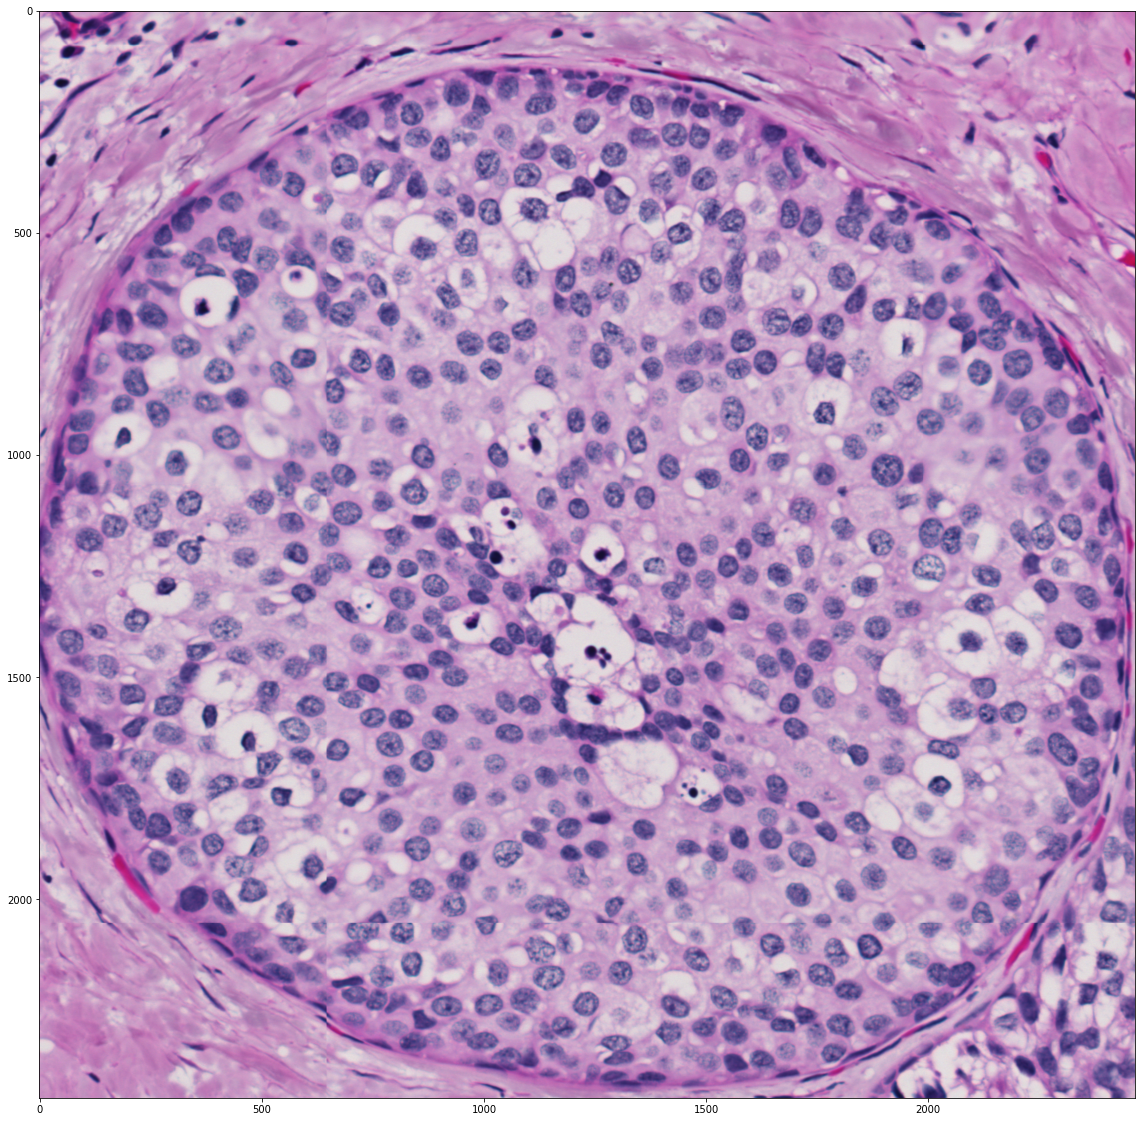

In [16]:
he_path = "input/example.tiff"
seg_path = "output/example.png"

HE =  mpimg.imread(he_path)
plt.figure(figsize=(20,20))
plt.imshow(HE)

Loading a segmentation result (H&E image segmented  in the previous pipeline step). Cell nuclei will project in yellow and bacground will be purple. 

STREAM b'IHDR' 16 13
STREAM b'IDAT' 41 8192


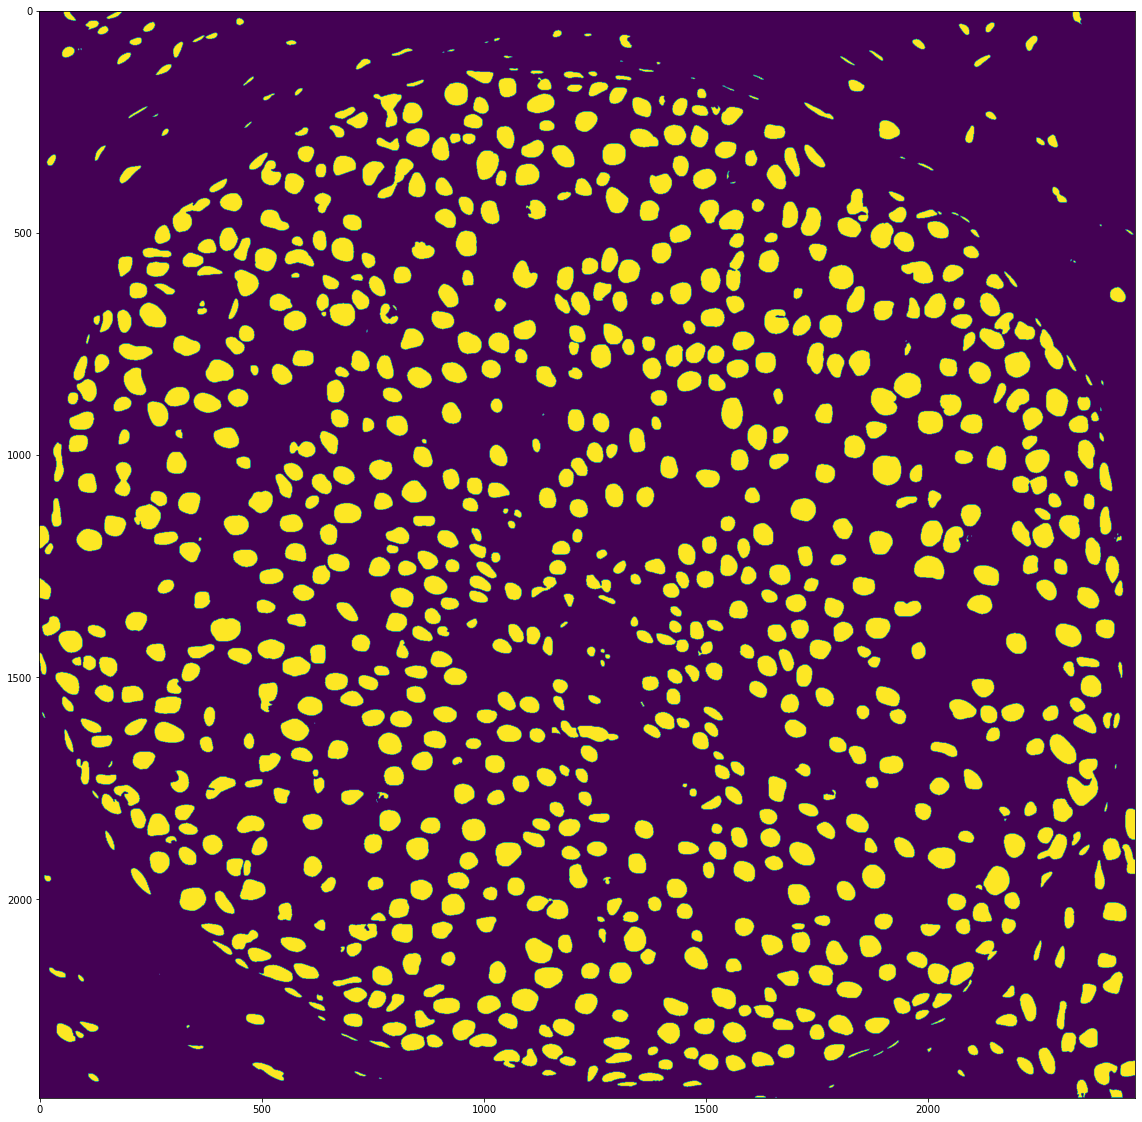

In [17]:
SEG = mpimg.imread(seg_path)
plt.figure(figsize=(20,20))
plt.imshow(SEG)

Initialising the SOM class object and Loading: 
1. trainedvecs7x7.mat: SOM grid that was pretrained in MATLAB on all the nuclei in the analysed dataset and represents self organised nuclear types present in the training dataset
2. Vectors.mat: the PCA vectors used to convert from the 1000 length SOM vector to a cropped nuclei image 

In [19]:
somhandle = SOM()
somhandle.readtrainedSOM('som_models/SOM_v3_12_13/trainedvecs7x7.mat')
somhandle.readPCAcoef('som_models/SOM_v3_12_13/vectors.mat')

deleted


Clustering the SOM nodes from the pretrained SOM gird

In [20]:
#clustering
class_vec = pd.DataFrame(somhandle.SOMvecs)
vec = class_vec.transpose()
Z = linkage(vec,"ward")
k=6 ### set number of classes
clusters = fcluster(Z, k, criterion='maxclust')
classess = []
for i in range(6):
    cls = np.where(clusters == (i+1))[0].tolist()
    classess.append(cls)

Loading clustered SOM classes to the initialised SOM object and setting color palette.

In [21]:
#load classes
somhandle.loadcellclasses(classess)

#load colorpermutation
somhandle.loadcolorpermute([1,3,5,2,4,0])

Segmenting the image

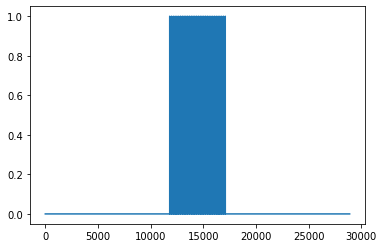

In [22]:
somhandle.segimg(seg_path)

Printing SOM node grid map colored by clustered SOM nodes, and distribution of nuclei on the segmented image with histograms of cell SOM nodes and hierarchical cell SOM classes

/home/kidzik/miniconda3/envs/som/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kidzik/miniconda3/envs/som/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(6,)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

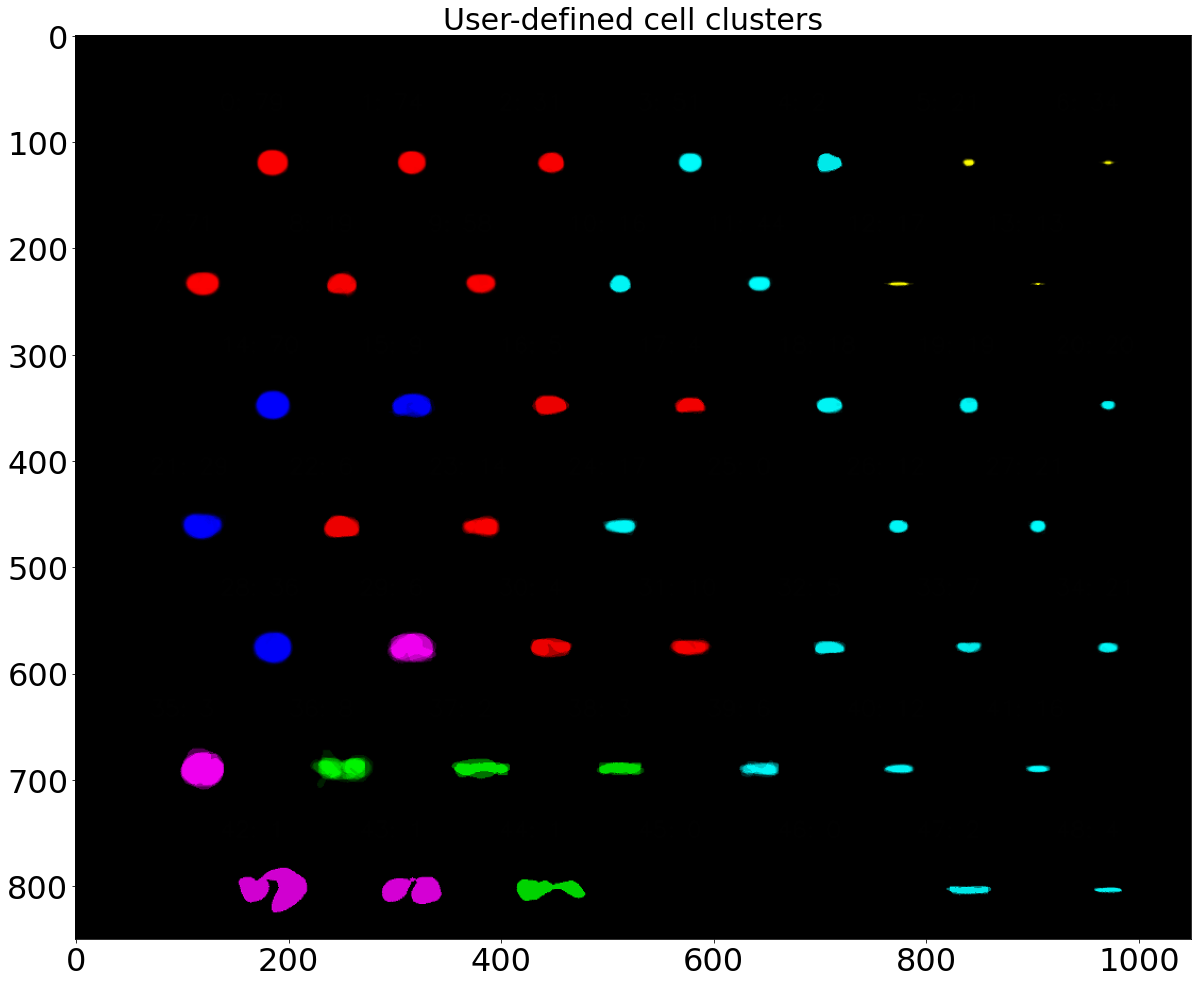

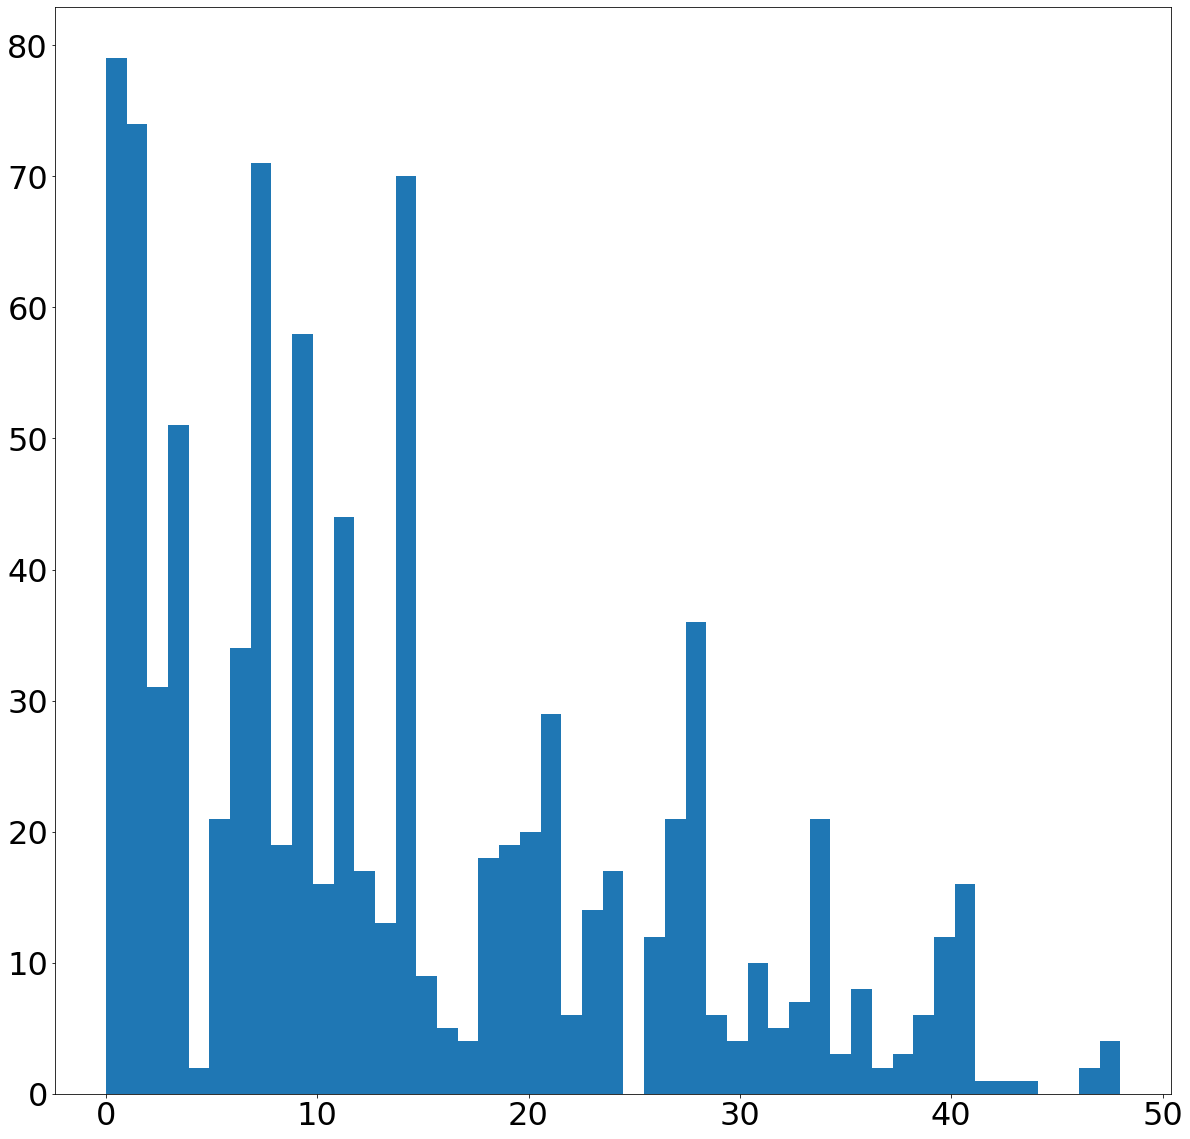

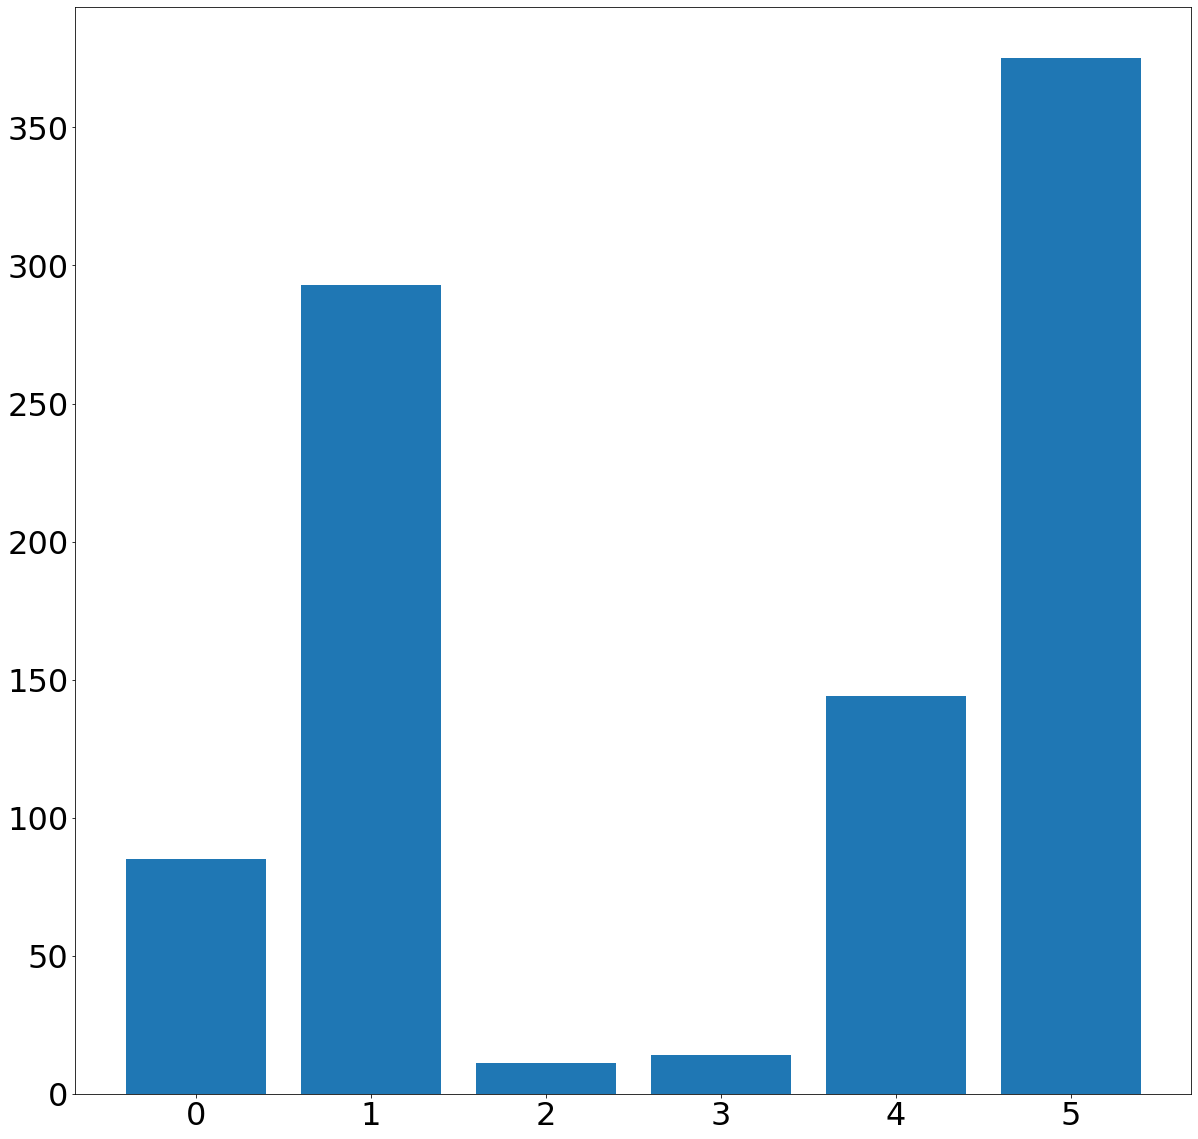

In [23]:
somhandle.printnodefig(seg_path)

Printing segmented H&E image with nuclei lebeled by the SOM node they were classified to.

length of cell classes:  6
length of cell dict:  922
shape of stats:  (922, 5)


<Figure size 1440x1440 with 0 Axes>

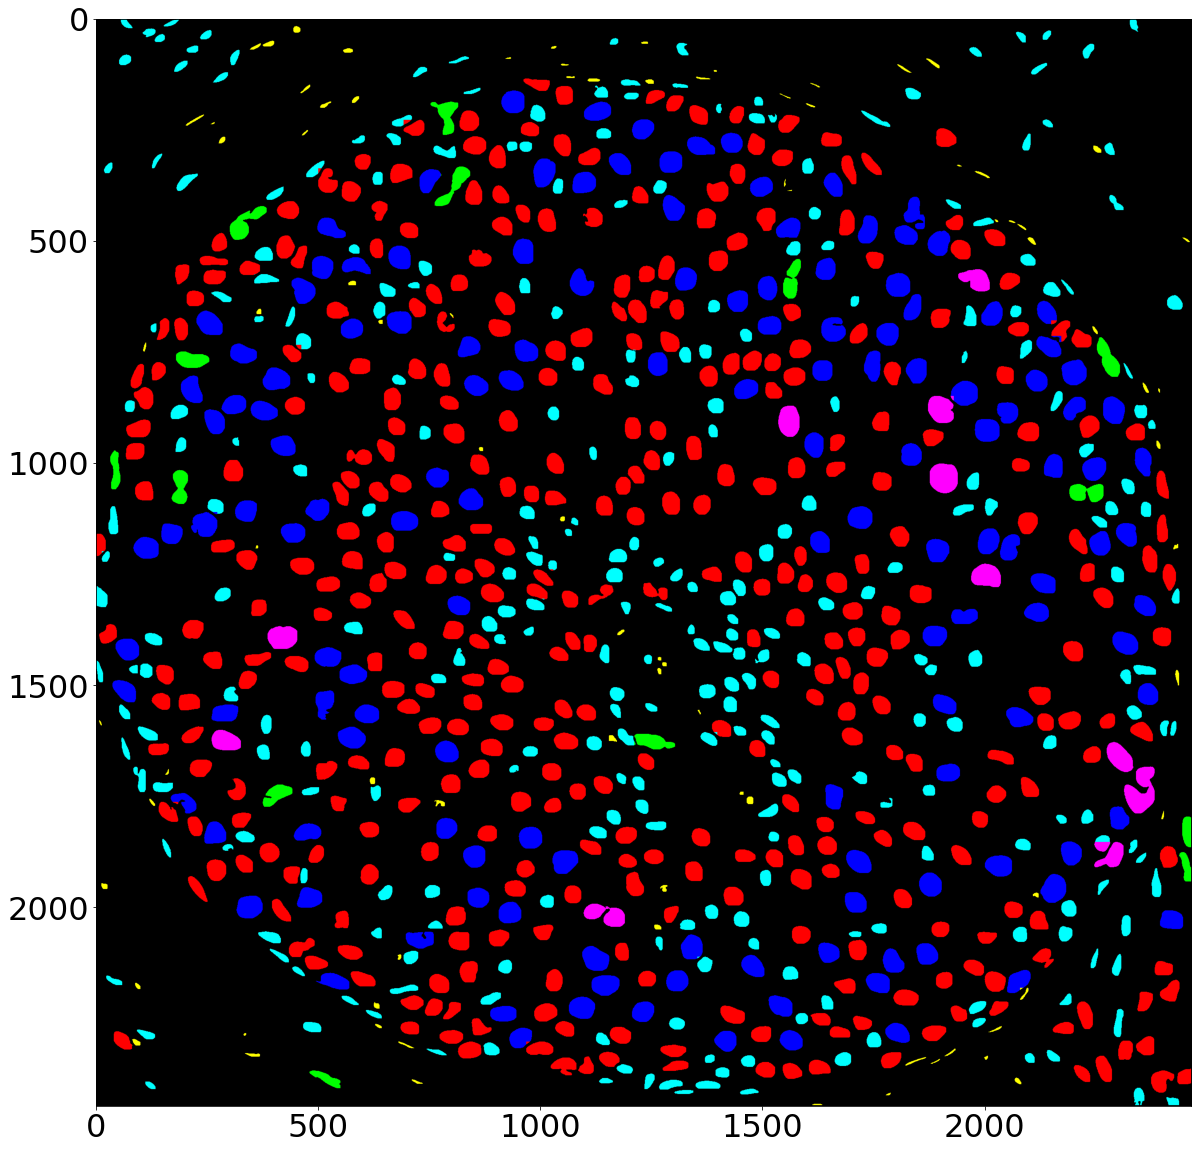

<Figure size 1440x1440 with 0 Axes>

In [9]:
somhandle.printcellfig(seg_path)
plt.figure(figsize=(20,20))

Now let's extract the results. 
We can extract:
    - segmented images of every cell
    - coordinates of every cell on the analysed picture 
    - information about cell SOM node and hierarchical SOM class  

Extracting a matrix of segmented cells and a matrix of cell coordinates and area with readimgandfilter(path) function.

This function reads in the image and filters out cells with bad shapes or with areas that are too small or too large and filters and sorts segmented cells.

Input:
- path - path of the image to process

Returns:
- stats - statistics for connected components of image, 3rd element of output
       from cv2.connectedComponentsWithStats()
- cells - image of segmented cells, with inside of cells = 1

In [24]:
stats, cells = somhandle.readimgandfilter(seg_path)

Let's print the matrix of segmented cells:

In [25]:
cells

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Let's print the matrix of cell coordinates and cell area with following columns:
0-x start, 1-y start, 2-x length, 3-y length , 4- area

In [26]:
stats.loc[0:10,]

,0,1,2,3,4
0,55,0,28,24,366
1,152,0,37,20,272
2,2326,0,20,32,413
3,444,18,17,16,209
4,105,23,30,21,395
5,234,27,27,22,388
6,2130,28,20,22,300
7,2070,31,23,25,358
8,132,36,24,19,323
9,1156,45,20,16,241


Extracting SOM node ID, hierarhical SOM class ID and cropped cell image with getsortedcelldict(path) function:

Input:
- path - path of the image for which we want the sortedcelldict

Returns:

sortedcelldict - a dictionary organized by cell indexes,
        containing cell images and info anout hierarhical SOM class and node ID
        
        key - index of cell - celldict["10"]
        value - list - [cell SOM hierarchical class, cell SOM node ID, segmented image of that cell]  


In [27]:
celldict = somhandle.getsortedcelldict(seg_path)

Let's print cell SOM hierarchical class, cell SOM node ID, segmented image of cell with an index "0"

In [28]:
celldict["0"]

[1,
 34,
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]